# Spectrum Sensing Delayed Feedback Reservoir (DFR)

## Import Packages

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

## Define Mackey-Glass Transfer Function

[Mackey-Glass equation on Scholarpedia](http://www.scholarpedia.org/article/Mackey-Glass_equation)

$$
y = \frac{2 \times x}{0.8 + 0.2(2.1 \times x)^{10}}
$$

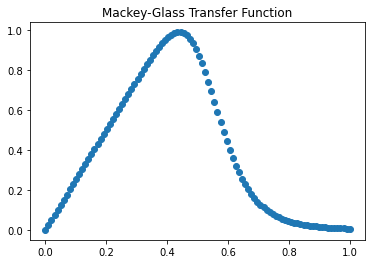

In [26]:
# mackey-glass function definition
def mg(x):
    a = 2
    b = 0.8
    c = 0.2
    d = 2.1
    p = 10

    return (a * x) / (b + c * np.power( (d * x), p) )

# graph mackey-glass function characteristics
x = np.linspace(0,1,100)
plt.title("Mackey-Glass Transfer Function")
plt.scatter(x,mg(x))
plt.show()

## Configure DFR Input Data Samples

In [27]:
num_samples = 6102

init_samples = 20
train_samples = 49 * init_samples
test_samples = num_samples - (init_samples + train_samples)



SNR = "-10"
# SNR = "0"

ss_data = np.genfromtxt(f'./spectrum_data/spectrum_data_adc_{SNR}db.csv', delimiter=',')
i_data = ss_data[:,0]
q_data = ss_data[:,1]

# max ADC output for signed/unsigned number
ADC_MAX_SIGNED = 2**11


i_data_norm = i_data / ADC_MAX_SIGNED
q_data_norm = q_data / ADC_MAX_SIGNED

x = np.sqrt(np.power(i_data_norm,2) + np.power(q_data_norm,2))
y = ss_data[:,2]

# define sample offsets
TRAIN_INIT_BEGIN = 0
TRAIN_DATA_BEGIN = init_samples
TEST_DATA_BEGIN = init_samples + train_samples

# index and save training and testing data
y_train = y[TRAIN_DATA_BEGIN:TEST_DATA_BEGIN]
y_test = y[TEST_DATA_BEGIN:]

## Configure DFR Properties

In [28]:
seed = 0

rng = np.random.default_rng(seed)

N = 50
gamma = 0.5
eta = 0.4
LAST_NODE = N - 1

reg = 1e-8

## Create DFR Masked Data Samples

In [29]:
mask = rng.uniform(-0.5,0.5,N)

# mask generation
masked_samples = np.empty((num_samples,N))
for i in range(num_samples):
    masked_samples[i] = mask * x[i]

## Initialize DFR for Training 

In [30]:
reservoir = np.zeros(N)
reservoir_history = np.zeros((train_samples,N))

for i in range(init_samples):
    for j in range(N):
        g_i = mg(gamma * masked_samples[TRAIN_INIT_BEGIN + i][j] + eta * reservoir[LAST_NODE])
        reservoir[1:N] = reservoir[0:LAST_NODE]
        reservoir[0] = g_i

## Run DFR with Training Data

In [31]:
for i in range(train_samples):
    for j in range(N):

        g_i = mg(gamma * masked_samples[TRAIN_DATA_BEGIN + i][j] + eta * reservoir[LAST_NODE])
        reservoir[1:N] = reservoir[0:LAST_NODE]
        reservoir[0] = g_i

    reservoir_history[i] = reservoir

## Calculate DFR Readout Weights using Ridge Regression

$$
W = \frac{\hat{y} \cdot X}{X^{T} \cdot X + \lambda I}
$$

In [32]:
W = np.dot(np.dot(y_train,reservoir_history),np.linalg.inv((np.dot(reservoir_history.T,reservoir_history)) + reg * np.eye(N)))

## Calculate Training Accuracy

In [33]:
# calculate DFR outputs
y_hat = reservoir_history.dot(W)

# create matrix for binary spectrum predictions
y_hat_bin = y_hat.copy()
y_hat_bin[y_hat_bin >= 0.5] = 1
y_hat_bin[y_hat_bin < 0.5] = 0

# calculate accuracy
train_accuracy = (y_hat_bin == y_train).mean()
print(f"Ridge Regression Training Accuracy:\t{train_accuracy}")

auc = roc_auc_score(y_train, y_hat)
print('AUC: %.3f' % auc)

Ridge Regression Training Accuracy:	0.7122448979591837
AUC: 0.710


## Run DFR with Testing Data

In [34]:
reservoir_history = np.zeros((test_samples,N))
for i in range(test_samples):
    for j in range(N):

        g_i = mg(gamma * masked_samples[TEST_DATA_BEGIN + i][j] + eta * reservoir[LAST_NODE])
        reservoir[1:N] = reservoir[0:LAST_NODE]
        reservoir[0] = g_i

    reservoir_history[i] = reservoir

## Calculate Testing Accuracy

Ridge Regression Testing Accuracy:	0.5372402979223834
AUC: 0.666


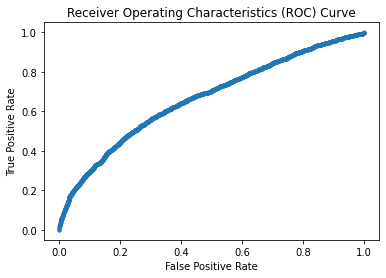

In [37]:
# calculate DFR outputs
y_hat = reservoir_history.dot(W)

# create matrix for binary spectrum predictions
y_hat_bin = y_hat.copy()
y_hat_bin[y_hat_bin >= 0.5] = 1
y_hat_bin[y_hat_bin < 0.5] = 0

# calculate accuracy
test_accuracy = (y_hat_bin == y_test).mean()
print(f"Ridge Regression Testing Accuracy:\t{test_accuracy}")

# calculate AUC
auc = roc_auc_score(y_test, y_hat)
print('AUC: %.3f' % auc)

# show plot
plt.clf()
fpr, tpr, _ = roc_curve(y_test, y_hat)
plt.plot(fpr, tpr, marker='.')
plt.title("Receiver Operating Characteristics (ROC) Curve")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

## Save DFR Properties for HLS Model

In [36]:
# mask
fh = open("./dfr_config/float_mask_data.txt","w")
for i in range(N):
    fh.write(str(mask[i]) + "\n")
fh.close()

# weights
fh = open("./dfr_config/float_weight_data.txt","w")
for i in range(N):
    fh.write(str(W[i]) + "\n")
fh.close()